# Pedro e o Lobo: Ambiente Realista

Na nossa situação, Pedro conseguia deslocar-se quase sem se cansar ou sentir fome. Num mundo mais realista, ele teria de sentar-se e descansar de vez em quando, além de alimentar-se. Vamos tornar o nosso mundo mais realista, implementando as seguintes regras:

1. Ao deslocar-se de um lugar para outro, Pedro perde **energia** e ganha algum **cansaço**.
2. Pedro pode recuperar energia ao comer maçãs.
3. Pedro pode livrar-se do cansaço descansando debaixo de uma árvore ou na relva (ou seja, ao caminhar para uma localização no tabuleiro com uma árvore ou relva - campo verde).
4. Pedro precisa encontrar e matar o lobo.
5. Para matar o lobo, Pedro precisa ter certos níveis de energia e cansaço; caso contrário, ele perde a batalha.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

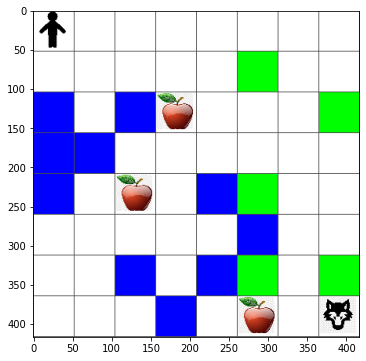

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definir estado

Nas novas regras do jogo, precisamos acompanhar a energia e a fadiga em cada estado do tabuleiro. Assim, iremos criar um objeto `state` que irá conter todas as informações necessárias sobre o estado atual do problema, incluindo o estado do tabuleiro, os níveis atuais de energia e fadiga, e se podemos derrotar o lobo enquanto estamos no estado terminal:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Função de Recompensa

A função de recompensa é uma parte essencial do sistema de aprendizagem por reforço. Ela define como o agente avalia as suas ações e orienta o comportamento em direção ao objetivo desejado.

### Objetivo da Função de Recompensa

O objetivo principal da função de recompensa é incentivar o agente a tomar ações que maximizem o retorno total ao longo do tempo. Isto é feito atribuindo valores positivos ou negativos às ações, dependendo do impacto que elas têm no progresso em direção ao objetivo.

### Estrutura da Função de Recompensa

A função de recompensa pode ser definida de várias formas, dependendo do problema específico. Aqui estão alguns exemplos comuns:

- **Recompensa baseada em desempenho**: O agente recebe uma recompensa proporcional ao sucesso de uma ação. Por exemplo, em um jogo, o agente pode ganhar pontos por atingir um objetivo.
- **Recompensa baseada em penalidades**: Penalidades são aplicadas para desencorajar comportamentos indesejados. Por exemplo, o agente pode perder pontos por cometer erros.
- **Recompensa combinada**: Combina recompensas e penalidades para criar um equilíbrio entre incentivo e correção.

### Considerações ao Projetar a Função de Recompensa

- **Clareza**: Certifique-se de que a função de recompensa seja fácil de entender e interpretar pelo agente.
- **Equilíbrio**: Evite recompensas excessivamente altas ou baixas, pois isso pode levar a comportamentos extremos ou apatia.
- **Alinhamento com o objetivo**: A função de recompensa deve refletir diretamente os objetivos do sistema.

### Exemplos de Funções de Recompensa

Aqui estão alguns exemplos de como uma função de recompensa pode ser implementada:

#### Exemplo 1: Recompensa Simples

```python
def reward_function(action):
    if action == "success":
        return 10
    elif action == "failure":
        return -5
    else:
        return 0
```

#### Exemplo 2: Recompensa Baseada em Distância

```python
def reward_function(distance_to_goal):
    if distance_to_goal == 0:
        return 100
    else:
        return -distance_to_goal
```

### Melhoria da Função de Recompensa

A função de recompensa pode ser ajustada e melhorada com base no desempenho do agente. Monitorar o comportamento do agente e realizar testes pode ajudar a identificar áreas onde a função de recompensa pode ser refinada.

### Conclusão

A função de recompensa é um componente crítico para orientar o comportamento do agente em sistemas de aprendizagem por reforço. Um design cuidadoso e iterativo pode garantir que o agente aprenda de forma eficaz e alcance os objetivos desejados.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritmo Q-Learning

O algoritmo de aprendizagem em si permanece praticamente inalterado, apenas usamos `state` em vez de apenas a posição do tabuleiro.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

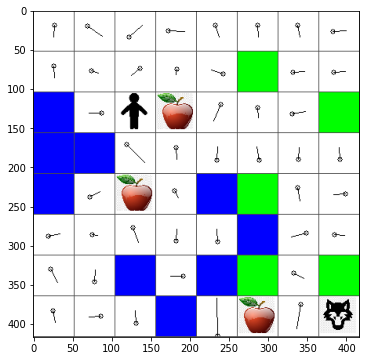

In [11]:
m.plot(Q)

## Resultados

Vamos ver se conseguimos treinar o Peter para enfrentar o lobo!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Agora vemos muito menos casos de afogamento, mas o Peter ainda não consegue sempre matar o lobo. Tente experimentar e veja se consegue melhorar este resultado ajustando os hiperparâmetros.


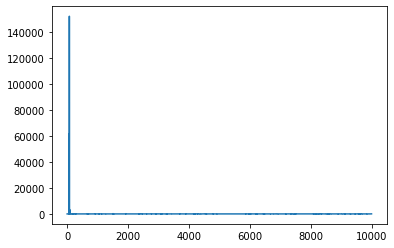

In [13]:
plt.plot(lpath)


---

**Aviso Legal**:  
Este documento foi traduzido utilizando o serviço de tradução por IA [Co-op Translator](https://github.com/Azure/co-op-translator). Embora nos esforcemos para garantir a precisão, é importante notar que traduções automáticas podem conter erros ou imprecisões. O documento original na sua língua nativa deve ser considerado a fonte autoritária. Para informações críticas, recomenda-se a tradução profissional realizada por humanos. Não nos responsabilizamos por quaisquer mal-entendidos ou interpretações incorretas decorrentes da utilização desta tradução.
